In [2]:
import os
os.environ["PYTHONHASHSEED"] = "0"
os.environ["TF_DETERMINISTIC_OPS"] = "1"  # deterministic GPU ops
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"  # deterministic cuDNN kernels

import tensorflow as tf
from tensorflow import keras
from keras import layers
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, roc_auc_score, average_precision_score, recall_score, precision_score

# Set the seeds for reproducibility
import random
SEED = 2648509283
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)
# tf.config.experimental.enable_op_determinism()

In [3]:
"""
Images will be resized to 80x80
Model class_weight will stay default. The dataset is imbalanced, but moderately - positive class (PNEUMONIA) has only 2.5 times more CXR images than negative (NORMAL).
"""

DATASET_DIR = "../data/chest_xray"
DATASET_PATH = Path(DATASET_DIR)
TRAIN_PATH = DATASET_PATH / "train"
TEST_PATH = DATASET_PATH / "test"
CLASSES = ["NORMAL", "PNEUMONIA"]
ID_TO_CLASS = {0:'NORMAL', 1:'PNEUMONIA'}
IMG_SIZE_SIDE = 80
IMG_SIZE = (IMG_SIZE_SIDE, IMG_SIZE_SIDE)
BATCH = 32
VAL_FRACTION = 0.15
PAD_TO_ASPECT_RATIO=False
CLASS_WEIGHTS = None

In [8]:
"""
Split test images in Train folder into Train/Val sets
We don't use existing Val folder because it has extremely small amount data
"""

train_ds, val_ds = keras.preprocessing.image_dataset_from_directory(
    TRAIN_PATH,
    labels='inferred',
    class_names=CLASSES,
    label_mode='binary',
    color_mode='grayscale',
    image_size=IMG_SIZE,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=PAD_TO_ASPECT_RATIO,
    batch_size=BATCH,
    validation_split=VAL_FRACTION,
    subset='both',
    shuffle=True,
    seed=SEED,
)

Found 5216 files belonging to 2 classes.
Using 4434 files for training.
Using 782 files for validation.


In [4]:
"""
Build Test set using images fron Test folder
"""

test_ds = keras.preprocessing.image_dataset_from_directory(
    TEST_PATH,
    labels='inferred',
    class_names=CLASSES,
    label_mode='binary',
    color_mode='grayscale',
    image_size=IMG_SIZE,
    pad_to_aspect_ratio=PAD_TO_ASPECT_RATIO,
    batch_size=BATCH,
    shuffle=False,
)

Found 624 files belonging to 2 classes.


2025-11-13 18:44:08.946441: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-11-13 18:44:08.946505: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-13 18:44:08.946509: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-11-13 18:44:08.946727: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-13 18:44:08.946767: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
"""
Standardizing the input images - adjust the contrast and brightness to standard range
"""

NORM = layers.Normalization(name="norm")

train_images = train_ds.map(lambda x, _: x, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
NORM.adapt(train_images)

2025-11-12 21:34:05.075203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
"""
###  VGG-style CNN with a GAP head  ###


We use strided conv layers (stride=2) instead of adding pooling layers
It may help the network to learn more patterns from the image

And we use GAP head (Global Average Pooling) instead of fully connected layer:
 - It reduces overfitting
 - Shrinks network size

Loss func: Binary Crossentropy -> Max
Matric to track during training (validation metric): PR AUC Score
 - Because we care more about predicting the positive class - PNEUMONIA

Our main evaluation metrics will be Recall (Sensitivity), because we our prediction must be sensitive to positive class - to not miss Pneumonia.
But also we will try to make a balanced predictions, so Precision is our 2nd metric - we don't wont to predict both classes as Pneumonia (control False Positives).
"""

def build_cnn(input_shape=(IMG_SIZE_SIDE, IMG_SIZE_SIDE, 1)):
    inputs = keras.Input(shape=input_shape)

    x = layers.RandomRotation(0.04, fill_mode="constant", seed=SEED)(inputs)
    x = layers.RandomZoom(0.05, fill_mode="constant", seed=SEED)(x)
    x = layers.RandomContrast(0.05, seed=SEED)(x)
    x = layers.RandomBrightness(0.05, seed=SEED)(x)

    # Use adapted stats
    x = NORM(x)

    x = layers.Conv2D(32, 5, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(64, 3, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(128, 3, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(128, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3, seed=SEED)(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    return keras.Model(inputs, x)

model = build_cnn()
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        keras.metrics.AUC(curve='PR', name='AUC_PR'),
        keras.metrics.AUC(curve='ROC', name='AUC_ROC'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.F1Score(name='F1'),
        keras.metrics.FBetaScore(name='F2', beta=2.0),
    ],
)

In [35]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 80, 80, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 80, 80, 1)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 80, 80, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_1               │ (None, 80, 80, 1)      │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness_1             │ (None, 80, 80, 1)      │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm (Normalization)            │ (None, 80, 80, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 40, 40, 32)     │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 40, 40, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 20, 20, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 20, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 10, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 10, 10, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 10, 10, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10, 10, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           12

 Total params: 724,456 (2.76 MB)

 Trainable params: 241,249 (942.38 KB)

 Non-trainable params: 707 (2.77 KB)

 Optimizer params: 482,500 (1.84 MB)

In [11]:
# Performance optimisations
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [12]:
# Validation metric
monitor_metric = "val_AUC_PR"

early = keras.callbacks.EarlyStopping(
    monitor=monitor_metric,
    mode="max",
    patience=6,
    restore_best_weights=True,
)

ckpt = keras.callbacks.ModelCheckpoint(
    "../model/model-1.keras",
    monitor=monitor_metric,
    mode="max",
    save_best_only=True,
)

rlr = keras.callbacks.ReduceLROnPlateau(
    monitor=monitor_metric,
    mode="max",
    factor=0.3,
    patience=2,
    min_lr=1e-6,
)

tb = keras.callbacks.TensorBoard(log_dir="../logs/tb_logs", histogram_freq=0)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    class_weight=CLASS_WEIGHTS,
    callbacks=[early, ckpt, rlr, tb],
)

Epoch 1/100


2025-11-12 21:34:13.626044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


139/139 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - AUC_PR: 0.9563 - AUC_ROC: 0.8810 - F1: 0.8545 - F2: 0.9362 - loss: 0.4367 - precision: 0.9303 - recall: 0.7811 - val_AUC_PR: 0.9474 - val_AUC_ROC: 0.8622 - val_F1: 0.8483 - val_F2: 0.9332 - val_loss: 0.9606 - val_precision: 0.7366 - val_recall: 1.0000 - learning_rate: 3.0000e-04
Epoch 2/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - AUC_PR: 0.9861 - AUC_ROC: 0.9612 - F1: 0.8545 - F2: 0.9362 - loss: 0.2387 - precision: 0.9471 - recall: 0.9363 - val_AUC_PR: 0.9852 - val_AUC_ROC: 0.9650 - val_F1: 0.8483 - val_F2: 0.9332 - val_loss: 0.8303 - val_precision: 0.7375 - val_recall: 1.0000 - learning_rate: 3.0000e-04
Epoch 3/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - AUC_PR: 0.9881 - AUC_ROC: 0.9690 - F1: 0.8545 - F2: 0.9362 - loss: 0.2051 - precision: 0.9463 - recall: 0.9574 - val_AUC_PR: 0.9954 - val_AUC_ROC: 0.9910 - val_F1: 0.8483 - val_F2: 0.9332 - val_loss: 0.2485 - val_precision: 0.8348 - val_recall: 1.0000 - learning_rate: 3.0000e-04
Epo

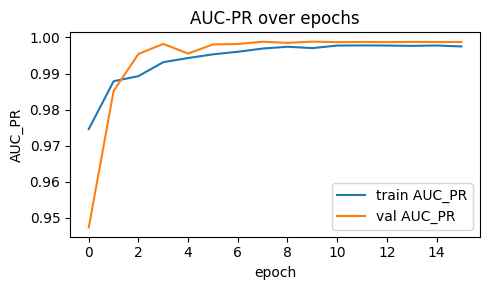

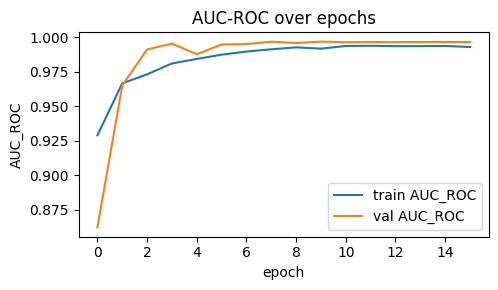

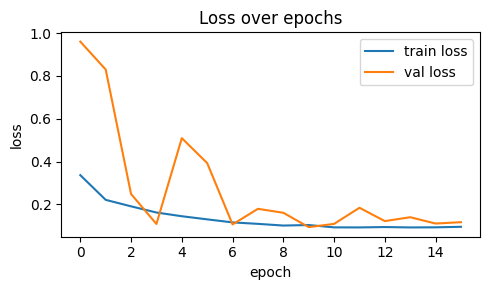

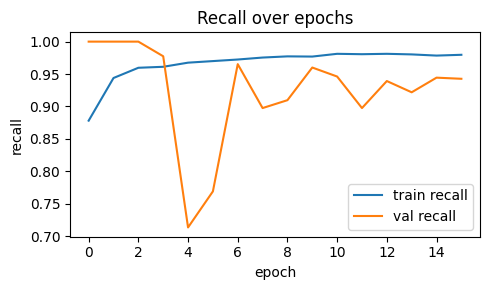

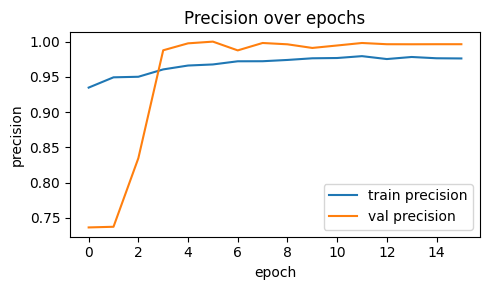

In [13]:
def plot_metric(h, key, title=None):
    plt.figure(figsize=(5,3))
    plt.plot(h.history[key], label=f"train {key}")
    val_key = f"val_{key}" if f"val_{key}" in h.history else None
    if val_key: plt.plot(h.history[val_key], label=f"val {key}")
    plt.xlabel("epoch"); plt.ylabel(key);
    if title: plt.title(title)
    plt.legend(); plt.tight_layout(); plt.show()

plot_metric(history, "AUC_PR", "AUC-PR over epochs")
plot_metric(history, "AUC_ROC", "AUC-ROC over epochs")
plot_metric(history, "loss", "Loss over epochs")
plot_metric(history, "recall", "Recall over epochs")
plot_metric(history, "precision", "Precision over epochs")

In [33]:
"""
Coosing the Threshold by the target value - Desired Recall is 94%
"""

def threshold_for_recall(y_true, y_prob, min_recall=0.94):
    prec, rec, thr = precision_recall_curve(y_true, y_prob)
    # Find all thresholds meeting the recall constraint
    ok = np.where(rec >= min_recall)[0]
    # cannot hit target recall
    if len(ok) == 0:
        # best achievable recall
        i = np.argmax(rec)
        t = thr[max(i-1, 0)]
        return t, prec[i], rec[i]
    # highest threshold with recall >= target
    i = ok[-1]
    # align index
    t = thr[max(i-1, 0)]
    return t, prec[i], rec[i]


y_true = np.concatenate([y.numpy().ravel() for _,y in val_ds])
y_prob = model.predict(val_ds, verbose=0).ravel()

best_t_target, prec, rec = threshold_for_recall(y_true, y_prob)

print(f"{'Threshold':15s}: {best_t_target:.4f}")
print(f"{'Recall':15s}: {rec:.4f}")
print(f"{'Precision':15s}: {prec:.4f}")

Threshold      : 0.6066
Recall         : 0.9410
Precision      : 0.9945


2025-11-12 21:53:34.872351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [32]:
"""
Model evaluation on Validation set
"""

best_t = best_t_target

# Get built-in metrics from model
val_metrics = model.evaluate(val_ds, verbose=0)
metric_names = model.metrics_names

print("\n--- Built-in Metrics ---")
for name, value in zip(metric_names, val_metrics):
    print(f"{name:15s}: {value:.4f}")

val_probs = model.predict(val_ds, verbose=0).ravel()
val_labels = np.concatenate([y.numpy().ravel() for _, y in val_ds.unbatch()])
val_preds = (val_probs >= best_t).astype(int)

recall = recall_score(val_labels, val_preds)
precision = precision_score(val_labels, val_preds)
accuracy = accuracy_score(val_labels, val_preds)
f1 = f1_score(val_labels, val_preds)
roc_auc = roc_auc_score(val_labels, val_probs)
pr_auc = average_precision_score(val_labels, val_probs)

print(f"\n--- Additional Metrics (threshold={best_t:.4f}) ---")
print(f"{'Recall':15s}: {recall:.4f}")
print(f"{'Precision':15s}: {precision:.4f}")
print("-----")
print(f"{'Accuracy':15s}: {accuracy:.4f}")
print(f"{'F1-Score':15s}: {f1:.4f}")
print(f"{'ROC-AUC':15s}: {roc_auc:.4f}")
print(f"{'PR-AUC (AP)':15s}: {pr_auc:.4f}")


--- Built-in Metrics ---
loss           : 0.0937
compile_metrics: 0.9988

--- Additional Metrics (threshold=0.6066) ---
Recall         : 0.9410
Precision      : 0.9927
-----
Accuracy       : 0.9514
F1-Score       : 0.9661
ROC-AUC        : 0.9967
PR-AUC (AP)    : 0.9988


2025-11-12 21:51:18.836010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
# Load model
loaded_model = keras.models.load_model("../model/model-1.keras")

# Run predictions on Test set
probs = loaded_model.predict(test_ds, verbose=0).ravel()
y_true = np.concatenate([y.numpy().ravel() for _, y in test_ds])

2025-11-13 18:46:13.021438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-11-13 18:46:13.796265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
"""
Get binary predictions by applying best threshold
"""

threshold = best_t_target
# threshold = 0.6066
y_pred = (probs >= threshold).astype(int)

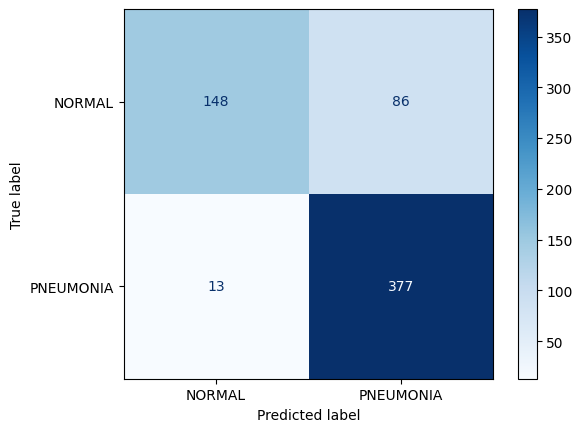

In [31]:
"""
Looking at Confusion matrix
"""

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
disp.plot(values_format='d', cmap='Blues');

In [34]:
TN, FP, FN, TP = cm.ravel()

# Sensitivity (don’t miss pneumonia)
recall = TP / (TP + FN) if (TP + FN) else 0.0
precision = TP / (TP + FP) if (TP + FP) else 0.0

print(f"Threshold={threshold:.3f}  Recall={recall:.3f}  Precision={precision:.3f}")

Threshold=0.607  Recall=0.967  Precision=0.814


---

We managed to build a model with following metrics:
- Recall: `96.7%`
- Precision: `81.4%`

Very good ability to not miss Pneumonia. But it struggles to detect the negative class - about 37% of Normal class is predicted as Pneumonia.

The current model Hyperparameters were chosen manually (by experimenting). And the CNN architecture is a custom one.
So our next steps to optimise the model performance:
- Apply cross-validation to find the best Hyperparameters for current architecture
- Apply Transfer Learning approach - find pre-trained model and fine-tune it using our dataset


---

### Visualise predictions - random samples

In [6]:
samples_test_ds = keras.preprocessing.image_dataset_from_directory(
    TEST_PATH,
    labels='inferred',
    class_names=CLASSES,
    label_mode='binary',
    color_mode='grayscale',
    pad_to_aspect_ratio=PAD_TO_ASPECT_RATIO,
    batch_size=BATCH,
    shuffle=False,
)

Found 624 files belonging to 2 classes.


2025-11-13 19:07:04.529850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


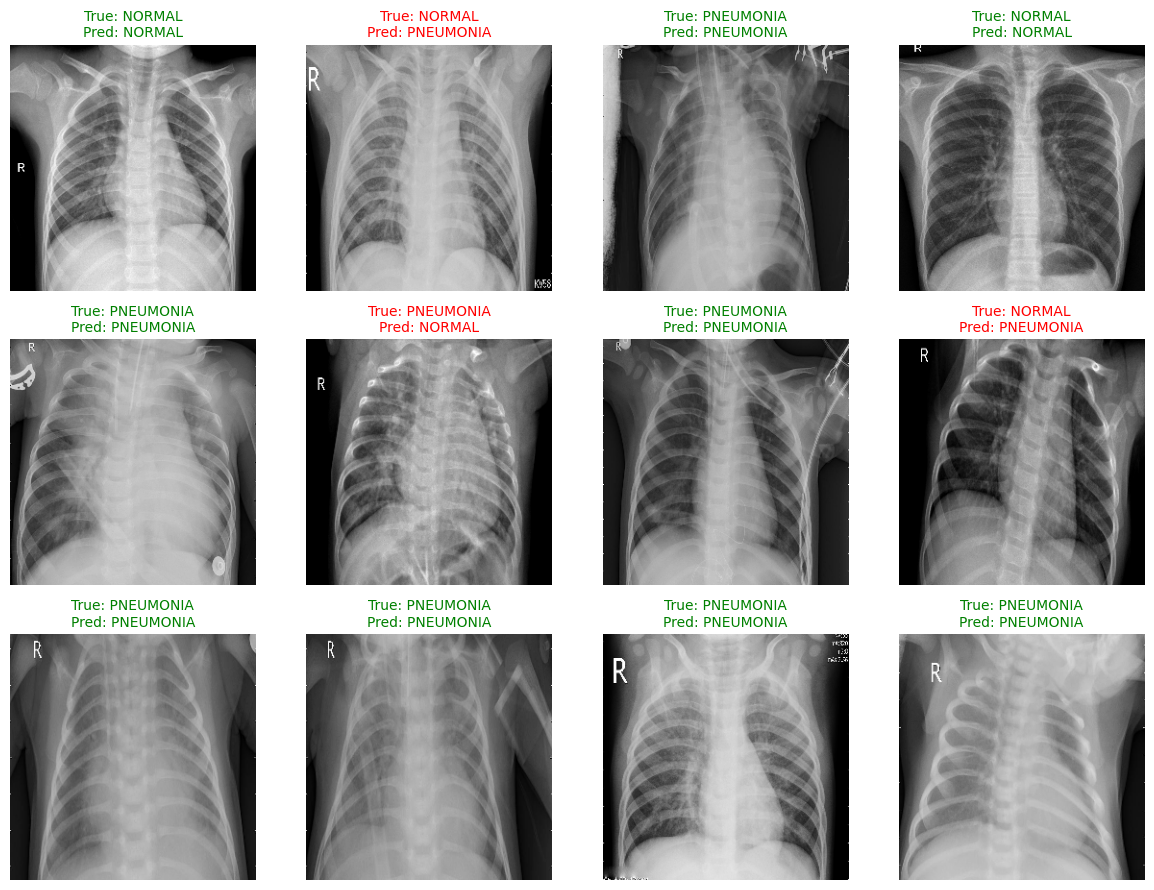

In [42]:
# Print random samples from Test split
test_samples = samples_test_ds.unbatch().shuffle(2048).take(12)
_threshold = 0.6066

rows, cols = 3, 4
plt.figure(figsize=(cols * 3, rows * 3))

for i, (img, true_label) in enumerate(test_samples):
    # Resize for prediction
    img_resized = tf.image.resize(img, [IMG_SIZE_SIDE, IMG_SIZE_SIDE])

    # Make prediction for this single image
    img_batch = tf.expand_dims(img_resized, axis=0)  # Add batch dimension
    pred_probs = loaded_model.predict(img_batch, verbose=0)
    pred_label = (pred_probs[0][0] >= _threshold).astype(int)

    # Get class names
    true_class = ID_TO_CLASS[int(true_label)]
    pred_class = ID_TO_CLASS[int(pred_label)]

    # Plot
    ax = plt.subplot(rows, cols, i + 1)
    plt.imshow(tf.squeeze(img, axis=-1), cmap="gray")

    color = 'green' if true_class == pred_class else 'red'
    ax.set_title(f"True: {true_class}\nPred: {pred_class}",
               fontsize=10, color=color)
    ax.axis("off")

plt.tight_layout()
plt.show();